-------------------
Data Pre Processing
-------------------

Loading Libraries

In [7]:
#importing libraries
import pandas as pd
import os
import librosa
import numpy as np
from tqdm import tqdm
import ast
import json
import matplotlib.pyplot as plt
import seaborn as sns

Feature Extraction Functions

In [2]:
#extracting mfcc

def features_extractor(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    print(file_name)
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    return mfccs_scaled_features

Reading Meta Data File

In [6]:
audio_dataset_path='D:/ocean-vue/Augmented Dataset/'
metadata=pd.read_csv('D:/ocean-vue/Augmented Dataset/metadata.csv')
metadata.head()

,Recording ID,File_name,Folder_ID,Class_ID,Class,File_path
0,1,1.wav,1,1,Cargo,Cargo\1\1.wav
1,2,2.wav,2,1,Cargo,Cargo\2\2.wav
2,3,3.wav,3,1,Cargo,Cargo\3\3.wav
3,4,4.wav,4,1,Cargo,Cargo\4\4.wav
4,5,5.wav,5,1,Cargo,Cargo\5\5.wav


Iterating through the audio files using metadata file in order to extract features from each audio file.

In [14]:
# Initialize a list to store extracted features and labels
extracted_features = []

# Iterate through metadata and extract features
for index_num, row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path), row['Class'], str(row['Folder_ID']), row['File_name']) #getting the filename to send for feature extraction

    final_class_label = row['Class'] #getting the class label of audio file
    data = features_extractor(file_name) #sending file for mfcc extraction
    extracted_features.append([data, final_class_label]) #appending the received features and class label to datagrame

In [74]:
extracted_features

In [10]:
extracted_features_df_for_csv = pd.DataFrame(extracted_features, columns=["Features", "Class"])

extracted_features_df_for_csv

,Features,Class
0,"[-351.62512, 86.87263, -14.980208, 21.255037, ...",Cargo
1,"[-433.63748, 102.78814, 4.263644, 31.529789, -...",Cargo
2,"[-459.4379, 118.98667, 14.566436, 32.147232, 1...",Cargo
3,"[-503.51062, 129.89467, 12.606634, 29.421465, ...",Cargo
4,"[-290.6702, 115.29109, -9.099596, 26.168022, -...",Cargo
...,...,...
547,"[-680.1012, 171.83755, -117.071945, -73.43425,...",Tug
548,"[-678.93353, 159.18694, -112.26985, -83.5203, ...",Tug
549,"[-685.2814, 171.26158, -114.44917, -72.09663, ...",Tug
550,"[-700.2786, 153.14021, -119.12963, -63.556595,...",Tug


------------------------------------------
REMOVE AFTER INVESTIGATION
------------------------------------------

In [105]:
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.tail()


,feature,class
547,"[-680.1012, 171.83755, -117.071945, -73.43425,...",Tug
548,"[-678.93353, 159.18694, -112.26985, -83.5203, ...",Tug
549,"[-685.2814, 171.26158, -114.44917, -72.09663, ...",Tug
550,"[-700.2786, 153.14021, -119.12963, -63.556595,...",Tug
551,"[-621.341, 183.7743, -130.46767, -67.64047, -2...",Tug


In [106]:
ex_data = extracted_features_df
ex_data.head()

,feature,class
0,"[-351.62512, 86.87263, -14.980208, 21.255037, ...",Cargo
1,"[-433.63748, 102.78814, 4.263644, 31.529789, -...",Cargo
2,"[-459.4379, 118.98667, 14.566436, 32.147232, 1...",Cargo
3,"[-503.51062, 129.89467, 12.606634, 29.421465, ...",Cargo
4,"[-290.6702, 115.29109, -9.099596, 26.168022, -...",Cargo


In [109]:
### Split the dataset into independent and dependent dataset
X=np.array(ex_data['feature'].tolist())
y=np.array(ex_data['class'].tolist())

In [110]:
### Label Encoding
###y=np.array(pd.get_dummies(y))
### Label Encoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [111]:
### Train Test Split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [95]:
import tensorflow as tf
print(tf.__version__)

2.13.0


In [96]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [112]:
### No of classes
num_labels=y.shape[1]
num_labels

4

In [113]:
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [114]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [115]:
## Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 100
num_batch_size = 32

#checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', verbose=1, save_best_only=True)
start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
14/14 [==============================] - ETA: 0s - loss: 64.4773 - accuracy: 0.2426
Epoch 1: val_loss did not improve from 0.89923
14/14 [==============================] - 3s 44ms/step - loss: 64.4773 - accuracy: 0.2426 - val_loss: 24.2702 - val_accuracy: 0.2342
Epoch 2/100
 9/14 [==================>...........] - ETA: 0s - loss: 38.0819 - accuracy: 0.2882
Epoch 2: val_loss did not improve from 0.89923
14/14 [==============================] - 0s 18ms/step - loss: 36.9601 - accuracy: 0.2698 - val_loss: 3.9625 - val_accuracy: 0.2793
Epoch 3/100
 8/14 [================>.............] - ETA: 0s - loss: 28.1117 - accuracy: 0.2383
Epoch 3: val_loss did not improve from 0.89923
14/14 [==============================] - 0s 20ms/step - loss: 25.5617 - accuracy: 0.2653 - val_loss: 2.1598 - val_accuracy: 0.2973
Epoch 4/100
11/14 [======================>.......] - ETA: 0s - loss: 20.3704 - accuracy: 0.2528
Epoch 4: val_loss did not improve from 0.89923
14/14 [===========================

In [116]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.23423422873020172


In [104]:
y_pred = model.predict(X_test)

4/4 [==============================] - 0s 4ms/step


------------------------------------------
------------------------------------------

Saving extracted features to csv

In [11]:
#extracted_features_df_for_csv['Features'] = extracted_features_df_for_csv['Features'].apply(lambda x: x.tolist()) #to same the extracted features in exact format
extracted_features_df_for_csv['Features'] = extracted_features_df_for_csv['Features'].apply(lambda x: ','.join(map(str, x)))

extracted_features_df_for_csv.to_csv('data_sample_extracted_augmented.csv', index=False)

Generating a sample heatmap of mfcc coefficients

In [13]:
mfcc_array = np.array(extracted_features_df_for_csv['Features'].tolist())

plt.figure(figsize=(10, 6))
sns.heatmap(mfcc_array, cmap='viridis', annot=False, xticklabels=False, yticklabels=False)
plt.title('MFCC Heatmap')
plt.xlabel('MFCC Coefficients')
plt.ylabel('Samples')
plt.show()

---------------
Model Pre Work
---------------

Loading Libraies

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter

Loading Dataset

In [18]:
ex_data = pd.read_csv(r'./data_sample_extracted_augmented.csv')
ex_data['Features'] = ex_data['Features'].apply(lambda x: list(map(float, x.split(','))))

In [19]:
ex_data

,Features,Class
0,"[-351.62512, 86.87263, -14.980208, 21.255037, ...",Cargo
1,"[-433.63748, 102.78814, 4.263644, 31.529789, -...",Cargo
2,"[-459.4379, 118.98667, 14.566436, 32.147232, 1...",Cargo
3,"[-503.51062, 129.89467, 12.606634, 29.421465, ...",Cargo
4,"[-290.6702, 115.29109, -9.099596, 26.168022, -...",Cargo
...,...,...
547,"[-680.1012, 171.83755, -117.071945, -73.43425,...",Tug
548,"[-678.93353, 159.18694, -112.26985, -83.5203, ...",Tug
549,"[-685.2814, 171.26158, -114.44917, -72.09663, ...",Tug
550,"[-700.2786, 153.14021, -119.12963, -63.556595,...",Tug


Splitting Features

In [20]:
X=np.array(ex_data['Features'].tolist())
y=np.array(ex_data['Class'].tolist())

In [21]:
print('mfcc Features       : ',X.shape)
print('Class Labels shape  : ',y.shape)

mfcc Features       :  (552, 40)
Class Labels shape  :  (552,)


In [22]:
X_copy_1 = X
y_copy_1 = y

X_copy_2 = X
y_copy_2 = y

In [23]:
#label encoding the class labels of y_copy_1

label_encoder = LabelEncoder()
y_copy_1 = label_encoder.fit_transform(y)

In [24]:
y_copy_1

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [52]:
X_train,X_test,y_train,y_test=train_test_split(X_copy_1,y_copy_1,test_size=0.2,random_state=0)

In [26]:
X_test

array([[-675.5819   ,  185.56732  , -105.49949  , ...,    1.3567432,
           4.185512 ,    3.2301981],
       [-674.72375  ,  165.77393  , -119.742035 , ...,    1.7825475,
           3.3501346,    2.4226906],
       [-555.7923   ,  161.03375  , -138.8322   , ...,    1.9353858,
           2.2562468,    2.556221 ],
       ...,
       [-668.44794  ,  181.1135   , -102.79528  , ...,    1.1645579,
           3.728306 ,    3.3315396],
       [-625.4786   ,  188.99529  , -123.15782  , ...,    3.059851 ,
           2.3438902,    2.3311086],
       [-807.1309   ,  121.512886 ,  -69.65257  , ...,    1.3782927,
           3.2404726,    1.9274442]])

Technique to handle imbalance data

In [27]:
# Create a list to store indices of samples from each category
category_indices = {category: np.where(y == category)[0] for category in np.unique(y)}

# Calculate the minimum number of samples across all categories
min_samples = min(len(indices) for indices in category_indices.values())

# Initialize lists to store train and test indices
train_indices = []
test_indices = []

# Define the fixed portion (percentage) for training and testing
train_portion = 0.8
test_portion = 0.2

In [28]:
# Iterate through each category
for category, indices in category_indices.items():
    # Select a fixed number of samples from each category
    num_samples = min_samples
    num_train_samples = int(train_portion * num_samples)
    num_test_samples = int(test_portion * num_samples)

    # Randomly shuffle the indices for each category
    shuffled_indices = np.random.permutation(indices)

    # Select samples for training and testing
    train_indices.extend(shuffled_indices[:num_train_samples])
    test_indices.extend(shuffled_indices[num_train_samples:num_train_samples + num_test_samples])


In [29]:
# Split the data using the selected train and test indices
X_train = X[train_indices]
y_train = y[train_indices]
X_test = X[test_indices]
y_test = y[test_indices]

In [30]:
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [31]:
y_train

array(['Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo',
       'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo',
       'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo',
       'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo',
       'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo',
       'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo',
       'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo',
       'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo',
       'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo',
       'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo',
       'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo',
       'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo',
       'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo',
       'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo',
       'Cargo', 'Car

In [53]:
# Count the occurrences of each category
category_count = Counter(y_train)

# Print the total count of each category
for category, count in category_count.items():
    print(f'{category}: {count}')

1: 112
3: 110
0: 113
2: 106


-----------------------
Machine Learning Models
-----------------------

---------
SVM

Loading Libraries

In [54]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.metrics import classification_report

Defining Parameters for SVM

In [55]:
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf'))
])

param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__gamma': [0.1, 1, 10] 
}

In [56]:
grid_search = GridSearchCV(svm_pipeline, param_grid, cv=4, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_svm_model = grid_search.best_estimator_

Fitting 4 folds for each of 9 candidates, totalling 36 fits


Testing Accuracy for SVM

In [57]:
test_accuracy = best_svm_model.score(X_test, y_test)

print("Best Parameters  ::", best_params)
print("Test Accuracy    ::", test_accuracy)

Best Parameters  :: {'svm__C': 10, 'svm__gamma': 0.1}
Test Accuracy    :: 0.6126126126126126


Confusion Matrix

Text(70.72222222222221, 0.5, 'Truth')

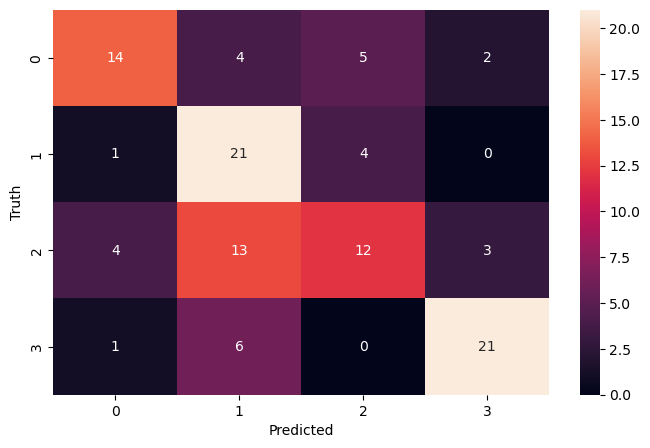

In [58]:
cm = confusion_matrix(y_test, grid_search.predict(X_test))
plt.figure(figsize = (8,5))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

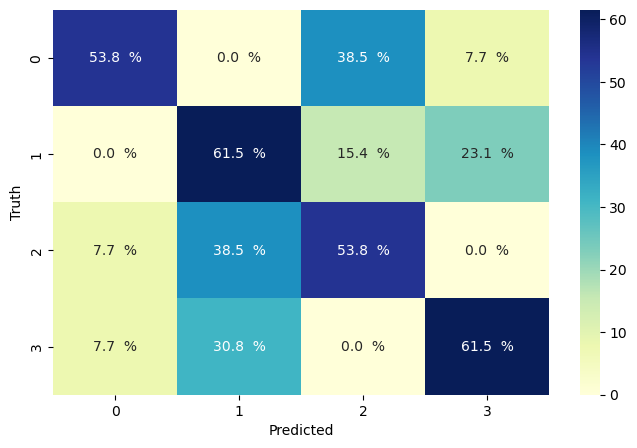

In [104]:
cm = confusion_matrix(y_test, grid_search.predict(X_test))

cm_percent = cm / cm.sum(axis=1)[:, np.newaxis] * 100
plt.figure(figsize=(8, 5))
sn.heatmap(cm_percent, annot=True, fmt=".1f", cmap="YlGnBu")
plt.xlabel('Predicted')
plt.ylabel('Truth')

ax = plt.gca()
for t in ax.texts:
    t.set_text(t.get_text() + "  %")
plt.show()

Precision & Recall

In [59]:
print(classification_report(y_test, grid_search.predict(X_test))) 

              precision    recall  f1-score   support

           0       0.70      0.56      0.62        25
           1       0.48      0.81      0.60        26
           2       0.57      0.38      0.45        32
           3       0.81      0.75      0.78        28

    accuracy                           0.61       111
   macro avg       0.64      0.62      0.61       111
weighted avg       0.64      0.61      0.61       111



In [60]:
X_test

array([[-675.5819   ,  185.56732  , -105.49949  , ...,    1.3567432,
           4.185512 ,    3.2301981],
       [-674.72375  ,  165.77393  , -119.742035 , ...,    1.7825475,
           3.3501346,    2.4226906],
       [-555.7923   ,  161.03375  , -138.8322   , ...,    1.9353858,
           2.2562468,    2.556221 ],
       ...,
       [-668.44794  ,  181.1135   , -102.79528  , ...,    1.1645579,
           3.728306 ,    3.3315396],
       [-625.4786   ,  188.99529  , -123.15782  , ...,    3.059851 ,
           2.3438902,    2.3311086],
       [-807.1309   ,  121.512886 ,  -69.65257  , ...,    1.3782927,
           3.2404726,    1.9274442]])

---------
Decision Tree

-----------------------
Deep Learning Models
-----------------------

--------------
Basic ANN Model

Importing Libraries

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

In [61]:
## No of classes
num_labels=y_copy_1.shape[0]
num_labels

552

Creating Model --- Needs to understand this one

In [62]:
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(len(np.unique(y_train)), activation='softmax'))

In [63]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 100)               4100      
                                                                 
 activation_6 (Activation)   (None, 100)               0         
                                                                 
 dropout_6 (Dropout)         (None, 100)               0         
                                                                 
 dense_9 (Dense)             (None, 200)               20200     
                                                                 
 activation_7 (Activation)   (None, 200)               0         
                                                                 
 dropout_7 (Dropout)         (None, 200)               0         
                                                                 
 dense_10 (Dense)            (None, 100)              

In [64]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [72]:
num_epochs = 100
num_batch_size = 32

#checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5',verbose=1, save_best_only=True)
start = datetime.now()

model.fit(X_train, y_train_lab, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test_encoded), callbacks=[checkpointer], verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
12/14 [========================>.....] - ETA: 0s - loss: 49.2937 - accuracy: 0.2396

ValueError: Data cardinality is ambiguous:
  x sizes: 111
  y sizes: 108
Make sure all arrays contain the same number of samples.

Testing Model Performance

Classification Report

In [48]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Decode labels
y_test_decoded = label_encoder.inverse_transform(y_test_encoded)
y_pred_decoded = label_encoder.inverse_transform(y_pred_classes)

# Print classification report
print(classification_report(y_test_decoded, y_pred_decoded))

4/4 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

       Cargo       0.00      0.00      0.00        27
   Passenger       0.25      1.00      0.40        27
      Tanker       0.00      0.00      0.00        27
         Tug       0.00      0.00      0.00        27

    accuracy                           0.25       108
   macro avg       0.06      0.25      0.10       108
weighted avg       0.06      0.25      0.10       108



c:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model Accuracy

In [51]:
test_accuracy=model.evaluate(X_test,y_test_encoded,verbose=0)
print(test_accuracy[1])

UnimplementedError: Graph execution error:

Detected at node 'Cast_1' defined at (most recent call last):
    File "c:\ProgramData\anaconda3\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\ProgramData\anaconda3\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\hasna\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\hasna\AppData\Roaming\Python\Python310\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\hasna\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelapp.py", line 736, in start
      self.io_loop.start()
    File "C:\Users\hasna\AppData\Roaming\Python\Python310\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "c:\ProgramData\anaconda3\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\ProgramData\anaconda3\lib\asyncio\base_events.py", line 1906, in _run_once
      handle._run()
    File "c:\ProgramData\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\hasna\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "C:\Users\hasna\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "C:\Users\hasna\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "C:\Users\hasna\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "C:\Users\hasna\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\hasna\AppData\Roaming\Python\Python310\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\hasna\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "C:\Users\hasna\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "C:\Users\hasna\AppData\Roaming\Python\Python310\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\hasna\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\hasna\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\hasna\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\hasna\AppData\Local\Temp\ipykernel_12320\313448609.py", line 1, in <module>
      test_accuracy=model.evaluate(X_test,y_test,verbose=0)
    File "C:\Users\hasna\AppData\Roaming\Python\Python310\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\hasna\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py", line 2200, in evaluate
      logs = test_function_runner.run_step(
    File "C:\Users\hasna\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py", line 4000, in run_step
      tmp_logs = self._function(dataset_or_iterator)
    File "C:\Users\hasna\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py", line 1972, in test_function
      return step_function(self, iterator)
    File "C:\Users\hasna\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py", line 1956, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\hasna\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py", line 1944, in run_step
      outputs = model.test_step(data)
    File "C:\Users\hasna\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py", line 1853, in test_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "C:\Users\hasna\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py", line 1179, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "C:\Users\hasna\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\compile_utils.py", line 605, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "C:\Users\hasna\AppData\Roaming\Python\Python310\site-packages\keras\src\utils\metrics_utils.py", line 77, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "C:\Users\hasna\AppData\Roaming\Python\Python310\site-packages\keras\src\metrics\base_metric.py", line 140, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "C:\Users\hasna\AppData\Roaming\Python\Python310\site-packages\keras\src\metrics\base_metric.py", line 708, in update_state
      y_true = tf.cast(y_true, self._dtype)
Node: 'Cast_1'
Cast string to float is not supported
	 [[{{node Cast_1}}]] [Op:__inference_test_function_16467]

Confusion Matrix

Text(70.72222222222221, 0.5, 'Truth')

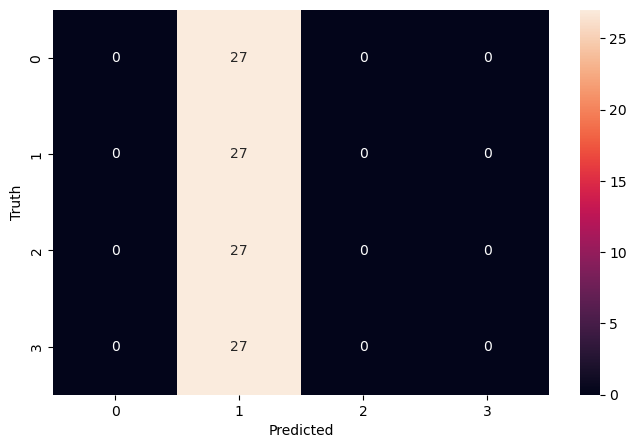

In [50]:
cm = confusion_matrix(y_test_decoded, y_pred_decoded)
plt.figure(figsize = (8,5))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

---------------
Unseen Data Testing
---------------